In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [43]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
#Declare a Base
Base = automap_base()

#use the base class to reflect the database tables
Base.prepare(engine, reflect=True)
# reflect the tables


In [45]:
# View all of the classes that automap found
#print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [48]:
#using the inspector to print the column names within the station and measurement tables and types
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column ["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [49]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column ["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [50]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
first_query_dt = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(first_query_dt)

# Perform a query to retrieve the data and precipitation scores
data = [Measurement.date, Measurement.prcp]
q_result= session.query(*data).filter(Measurement.date >=first_query_dt).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
#Sort the dataframe by date
precip_df=pd.DataFrame(q_result, columns=['Date', 'Precipitation']).sort_values(["Date"], ascending = True)
precip_df=precip_df.dropna(how='any')
precip_df=precip_df.set_index("Date")
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


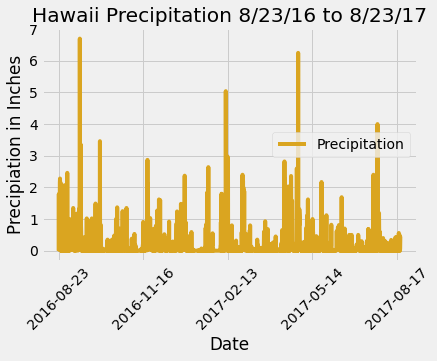

In [52]:
# Use Pandas Plotting with Matplotlib to plot the dataframe
precip_df.plot(title = 'Hawaii Precipitation 8/23/16 to 8/23/17',
                      color='goldenrod')
plt.xticks(rotation=45)
plt.ylabel('Precipiation in Inches')
plt.xlabel("Date")
plt.savefig("Hawaii Precipitaiton.png")
plt.show()

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [55]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
act_st= session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
act_st

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_act=act_st[0][0]
#most_act
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
              func.avg(Measurement.tobs)).filter(Measurement.station == most_act).all()

[(54.0, 85.0, 71.66378066378067)]

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act_st_temp= session.query(Measurement.tobs).\
    filter(Measurement.date >=first_query_dt).\
    filter(Measurement.station == most_act).all()
act_st_temp

act_st_temp=pd.DataFrame(act_st_temp, columns = ['temperature'])

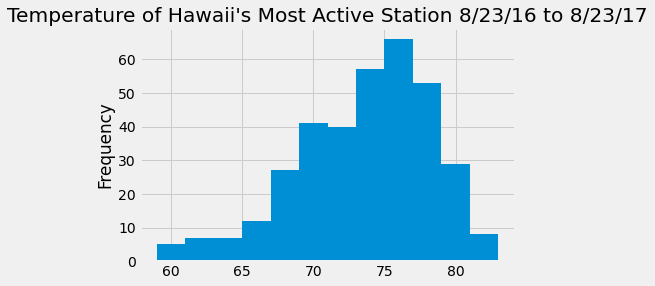

In [58]:
act_st_temp.hist(bins=12)
plt.ylabel('Frequency')
plt.title("Temperature of Hawaii's Most Active Station 8/23/16 to 8/23/17")
plt.savefig("temp histo.png")

# Close session

In [59]:
# Close Session
session.close()

In [ ]:
#flask setup
app = Flask(_name_)

In [ ]:
#Flask routes
@app.route("/")
def Hawaii():
    return(
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation"
        f"/api/v1.0/stations"
        f"/api/v1.0/tobs"
        f"/api/v1.0/<start>"
        f"/api/v1.0/<start>/<end>"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    session= Session(engine)
    
    first_query_dt= dt.date(2017,8,23)
    data = [Measurement.date, Measurement.prcp]
    q_result= session.query(*data).filter(Measurement.date >=first_query_dt).all()
    
    session.close()
    
    precipit = list(np.ravel(q_result))
    
    return jsonify(precipit)

@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    
    act_st= session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
    
    session.close()
    
    station = list(np.ravel(act_st))
    
    return jsonify(station)

@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)
    
    most_act = "USC00519281" 
    first_query_dt= dt.date(2017,8,23)
    
    act_st_temp= session.query(Measurement.tobs).\
    filter(Measurement.date >=first_query_dt).\
    filter(Measurement.station == most_act).all()
    
    session.close()
    
    tob = list(np.ravel(act_st_temp))
    
    return jsonify(tob)
    
@app.route("/api/v1.0/<start>")
def start(start_date):
    session = Session(engine)
    
    beg_date= start_date
    q_results= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\ 
              func.avg(Measurement.tobs)).filter(Measurement.date >=beg_date).all()
    
    session.close()
    
    date = list(np.ravel(q_results))
    
    return jsonify(date)

@app.route("/api/v1.0/<start>/<end>")
def dates (date_1, date_2):
    session = Session (engine)
        
    start = date_1
    end = date_2
    q_results= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\ 
              func.avg(Measurement.tobs)).filter(Measurement.date >=start).filter(Measurement.date <=end).all()
    
    session.close()
    
    dates = list(np.ravel(q_results))
    
    return jsonify (dates)